# Microscopy Cell Segmentation Using Unet 3D 3plus

UNet, which is one of deep learning networks with an encoder-decoder architecture, is widely used in medical image segmentation. Combining multi-scale features is one of important factors for accurate segmentation. UNet++ was developed as a modified Unet by designing an architecture with nested and dense skip connections. However, it does not explore sufficient information from full scales and there is still a large room for improvement. 

[UNET 3plus](https://arxiv.org/abs/2004.08790)  full-scale skip connections convert the inter-connection between the encoder and decoder as well as intra-connection between the decoder sub-networks. Both UNet with plain connections and UNet++ with nested and dense connections are short of exploring sufficient information from full scales, failing to explicitly learn position and boundary of an organ. To remedy the defect in UNet and UNet++, each decoder layer in UNet 3+ incorporates both smaller- and same-scale feature maps from encoder and larger-scale feature maps from decoder, which capturing fine-grained details and coarse-grained semantics in full scales.

This example of UNET 3D 3plus to modification of UNET 3plus to segmentation 3D dataset. We are showcasing UNET 3D 3plus to segment [electronic microscopy 3D cell dataset](https://leapmanlab.github.io/dense-cell/). 

## Getting things ready

Lets import the necessary packages:

In [1]:
import tempfile

import numpy as np

import fastestimator as fe
from em_3d import load_data
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, VerticalFlip
from fastestimator.op.numpyop.univariate import ChannelTranspose, Minmax
from fastestimator.op.numpyop.univariate.expand_dims import ExpandDims
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.loss import FocalLoss
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.op.tensorop.resize3d import Resize3D
from fastestimator.op.tensorop.argmax import Argmax
from fastestimator.trace.adapt import EarlyStopping, ReduceLROnPlateau
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Dice
from fastestimator.util import ImageDisplay, GridDisplay

## Save Gif

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation, rc

rc('animation', html='jshtml')

def apply_mask(image, mask, color, alpha=0.1):
    """
        Apply the given mask to the image.
        
        image: the input image(H, W, D, C)
        mask: the mask to overlay(H, W, D)
        color_mapping: list of color value [C]
        
    """
    channels = image.shape[-1]
    for c in range(channels):
        image[:, :, :, c] = np.where(mask == 1,
                                  image[:, :, :, c] *
                                  (1 - alpha) + alpha * color[c],
                                  image[:, :, :, c])
    return image


def generate_mask_overlay_image(image, mask, color_mapping):
    """
        Generate a image overlaying mask over it.
        
        image: the input image(H, W, D, C)
        mask: the mask to overlay(H, W, D, class)
        color_mapping: a dictionary mapping input classes to colors(eg: {0: [0, 0, 0], 1: [0, 40, 255]})
                       The dictionary should have length "class" and each element should contain list of length "C"
                       image and color_mapping are expected to be in same format(eg 0-1 or 0-255)
    """
    combined_image = copy.deepcopy(image)
    classes = mask.shape[-1]
    for i in range(classes):
        combined_image = apply_mask(combined_image, mask[:,:,:,i], color_mapping[i])
        
    return combined_image

def create_animation(images, labels):
    """
        create animation combining input image and mask
        
        image: the input image(H, W, D, 3)
        labels: the image to compare with(H, W, D, 3)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.axis('off')
    ax2.axis('off')

    im1 = ax1.imshow(images[:, :, 0,:])
    im2 = ax2.imshow(labels[:, :, 0,:])

    fig.show()

    im = [im1, im2]

    def animate_func(i):
        im[0].set_array(images[:, :, i,:])
        im[1].set_array(labels[:, :, i,:])
        return [im]

    return animation.FuncAnimation(fig,
                                   animate_func,
                                   frames=images.shape[-2],
                                   interval=images.shape[-2]*4)

color_mapping = {
    0: [0, 0, 0],
    1: [0.0, 0.16, 1.0],
    2: [0.0, 0.83, 1.0],
    3: [0.49, 1.0, 0.48],
    4: [0.50, 0.0, 0.0],
    5: [1.0, 0.28, 0.0],
    6: [1.0, 0.90, 0.0]}

def save_gif(image, label, color_mapping, file_name):
    overlay_image = generate_mask_overlay_image(image, label, color_mapping)
    create_animation(image, overlay_image).save(file_name)

Next, let's set up some hyperparameters related to the task:

In [3]:
batch_size = 1
epochs = 40
log_steps = 20
height = 256
width = 256
depth = 24
channels = 1
num_classes = 6
filters = 64
learning_rate = 1e-3
train_steps_per_epoch = None
eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()
data_dir = None

## Importing Dataset

Electronic Microscopy 3D cell dataset, consists of 2 3D images, one 800x800x50 and the other 800x800x24. The 800x800x50 is used as training dataset and 800x800x24 is used for validation. Instead of using the entire 800x800 images, the 800x800x50 is tiled into 256x256x24 tiles with an overlap of 128 producing around 75 training images and similarly the 800x800x24 image is tiled to produce 25 validation images.

In [4]:
train_data, eval_data = load_data(data_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 95.3M/95.3M [00:11<00:00, 8.17MB/s]


In [5]:
print("training dataset length is {}".format(len(train_data)))
print("evaluation dataset length is {}".format(len(eval_data)))

print("dataset sample:")
print("Image Shape: ", train_data[0]['image'].shape)
print("Label Shape: ", train_data[0]['label'].shape)

training dataset length is 75
evaluation dataset length is 25
dataset sample:
Image Shape:  (256, 256, 24)
Label Shape:  (256, 256, 24, 6)


The `image`is a 256x256x24 numpy array of uint16.  

The `label` is a 256x256x24*6 encoded(6 classes) numpy array. Semantic label files classify each image voxel into one of six classes, indexed from 0-5:

<table>
<tr><td><b>Index</b> </td><td><b>Color </b></td><td><b>Class name</b></td></tr>
<tr><td>0 </td><td>Dark Blue </td><td>Cell</td></tr>
<tr><td>1 </td><td>Cyan </td><td>Mitochondria</td></tr>
<tr><td>2 </td><td>Green </td><td>Alpha granule</td></tr>
<tr><td>3 </td><td>Yellow </td><td>Canalicular vessel</td></tr>
<tr><td>4 </td><td>Red	Dense </td><td>granule body</td></tr>
<tr><td>5 </td><td>Purple </td><td>granule core</td></tr>
</table>

## Creating Pipeline

Now that both training and validation datasets are created, we use `Pipeline` to define the preprocessing operations:


* We are using HorizontalFlip and VerticalFlip as our applied data agumentations.


* ExpandDims is used to expand the last channel(256x256x24)-> (256x256x24x1).

In [6]:
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    batch_size=batch_size,
    ops=[
        Sometimes(numpy_op=HorizontalFlip(image_in="image", mask_in="label", mode='train')),
        Sometimes(numpy_op=VerticalFlip(image_in="image", mask_in="label", mode='train')),
        Minmax(inputs="image", outputs="image"),
        ExpandDims(inputs="image", outputs="image"),
        ChannelTranspose(inputs=("image", "label"), outputs=("image", "label"), axes=(3, 0, 1, 2))
    ])

In [7]:
data = pipeline.get_results(mode='train')

In [8]:
image = np.squeeze(data['image'].numpy())
label = np.squeeze(data['label'].numpy())
print("Image shape: ", image.shape,"    Mask shape:", label.shape)

# expand the image to 3 channels if its gray scale image
label = np.transpose(label, (1, 2, 3, 0))

Image shape:  (256, 256, 24)     Mask shape: (6, 256, 256, 24)


# Visualizing Sample Data:

Visualization of single slice of the pipeline output.

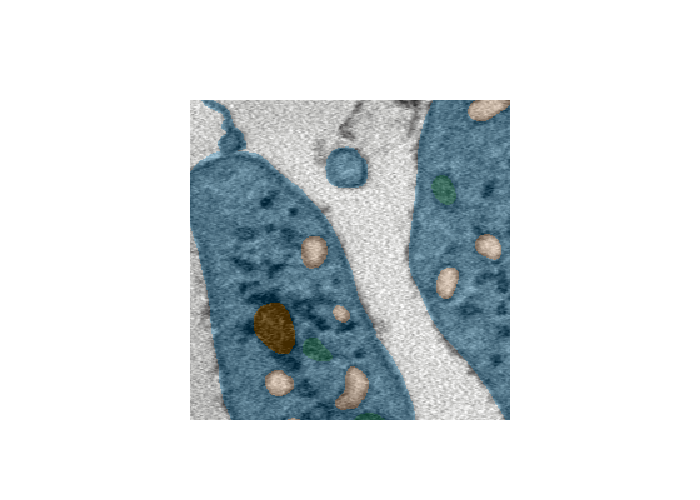

In [9]:
ImageDisplay(image=image[:,:,0], masks=label[:,:,0]).show()

Saving multi slice visualization as gif.

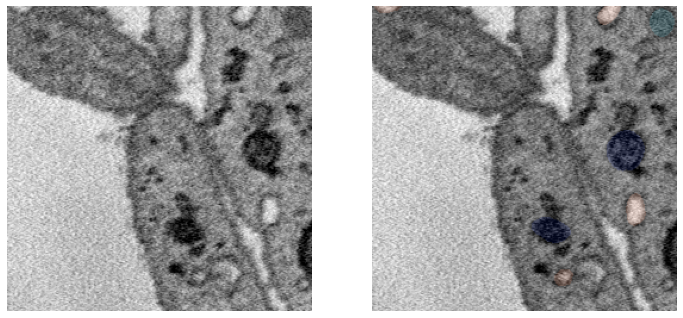

In [10]:
# adding ground truth layer
input_gt = np.ones(label.shape[:-1] + (1,), dtype=label.dtype)
input_gt[np.sum(label, axis=-1)==1] = 0
label_out = np.concatenate((input_gt, label), axis=-1)

image = np.tile(np.expand_dims(image, -1), 3)

save_gif(image, label, color_mapping, 'training_data.gif')

Visualization of multiple slices of the pipeline out which is generated offline.

<img src='https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/apphub/unet3d_3plus/sample_input.gif?raw=true' width="800" height="400">

## UNET 3D 3Plus

In [11]:
from typing import Tuple

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.init import kaiming_normal_ as he_normal

class TotalLoss(TensorOp):
    def forward(self, data, state):
        focal_loss, ce_loss = data
        total_loss = focal_loss + ce_loss
        return total_loss
    
class StdSingleConvBlock(nn.Module):
    """A UNet3D StdSingleConvBlock block.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.BatchNorm3d(in_channels),
                                    nn.ReLU(inplace=True),
                                    nn.Conv3d(in_channels, out_channels, kernel_size=3, padding="same"))

        for layer in self.layers:
            if isinstance(layer, nn.Conv3d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out = self.layers(x)
        return out


class ConvBlock(nn.Module):
    """A UNet3D ConvBlock block.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=3, padding="same"))

        for layer in self.layers:
            if isinstance(layer, nn.Conv3d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out = self.layers(x)
        return out


class StdDoubleConvBlock(nn.Module):
    """A UNet3D StdDoubleConvBlock block.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            StdSingleConvBlock(in_channels, out_channels),
            StdSingleConvBlock(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out = self.layers(x)
        return out


class StdConvBlockSkip(nn.Module):
    """A UNet3D StdConvBlockSkip block skipping batch normalization.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
    """
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.layers = nn.Sequential(ConvBlock(in_channels, out_channels),
                                    StdSingleConvBlock(out_channels, out_channels))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layers(x)
        return out


class UpsampleBlock(nn.Module):
    """A UNet3D UpsampleBlock block.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
        scale_factor: scale factor to up sample
        kernel_size: size of the kernel
    """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int, kernel_size: int = 3) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=scale_factor, mode='trilinear', align_corners=False),
            nn.Conv3d(in_channels, out_channels, kernel_size, padding="same"),
        )

        for layer in self.layers:
            if isinstance(layer, nn.Conv3d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out = self.layers(x)
        return out


class DownSampleBlock(nn.Module):
    """A UNet3D DownSampleBlock block.

    Args:
        in_channels: How many channels enter the encoder.
        out_channels: How many channels leave the encoder.
        scale_factor: scale factor to down sample
        kernel_size: size of the kernel
    """
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int, kernel_size: int = 3) -> None:
        super().__init__()
        self.scale_factor = scale_factor
        self.layers = nn.Sequential(nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding="same"))

        for layer in self.layers:
            if isinstance(layer, nn.Conv3d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        out = self.layers(F.max_pool3d(x, self.scale_factor))
        return out


class UNet3D3Plus(nn.Module):
    """A Attention UNet3D 3plus implementation in PyTorch.

    Args:
        input_size: The size of the input tensor (channels, height, width).
        output_channel: The number of output channels.

    Raises:
        ValueError: Length of `input_size` is not 3.
        ValueError: `input_size`[1] or `input_size`[2] is not a multiple of 16.
    """
    def __init__(self,
                 input_size: Tuple[int, int, int] = (1, 128, 128, 24),
                 output_channel: int = 1,
                 channels: int = 64) -> None:
        UNet3D3Plus._check_input_size(input_size)
        super().__init__()
        self.input_size = input_size
        self.enc1 = StdConvBlockSkip(in_channels=input_size[0], out_channels=channels)
        self.enc2 = StdDoubleConvBlock(in_channels=channels, out_channels=channels * 2)
        self.enc3 = StdDoubleConvBlock(in_channels=channels * 2, out_channels=channels * 4)
        self.bottle_neck = StdDoubleConvBlock(in_channels=channels * 4, out_channels=channels * 8)

        self.up5_4 = UpsampleBlock(in_channels=channels * 8, out_channels=channels, scale_factor=2)
        self.up5_3 = ConvBlock(in_channels=channels * 4, out_channels=channels)
        self.down5_2 = DownSampleBlock(in_channels=channels * 2, out_channels=channels, scale_factor=2)
        self.down5_3 = DownSampleBlock(in_channels=channels, out_channels=channels, scale_factor=4)

        self.conv5 = StdSingleConvBlock(in_channels=channels * 4, out_channels=4 * channels)

        self.up6_4 = UpsampleBlock(in_channels=channels * 8, out_channels=channels, scale_factor=4)
        self.up6_3 = UpsampleBlock(in_channels=channels * 4, out_channels=channels, scale_factor=2)
        self.up6_2 = ConvBlock(in_channels=channels * 2, out_channels=channels)
        self.down6_1 = DownSampleBlock(in_channels=channels, out_channels=channels, scale_factor=2)

        self.conv6 = StdSingleConvBlock(in_channels=channels * 4, out_channels=4 * channels)

        self.up7_4 = UpsampleBlock(in_channels=channels * 8, out_channels=channels, scale_factor=8)
        self.up7_3 = UpsampleBlock(in_channels=channels * 4, out_channels=channels, scale_factor=4)
        self.up7_2 = UpsampleBlock(in_channels=channels * 4, out_channels=channels, scale_factor=2)
        self.conv7_1 = ConvBlock(in_channels=channels, out_channels=channels)

        self.conv7 = StdSingleConvBlock(in_channels=channels * 4, out_channels=4 * channels)

        self.dec1 = nn.Sequential(nn.BatchNorm3d(channels * 4),
                                  nn.ReLU(inplace=True),
                                  nn.Conv3d(channels * 4, output_channel, 1, padding="same"),
                                  nn.Sigmoid())

        for layer in self.dec1:
            if isinstance(layer, nn.Conv3d):
                he_normal(layer.weight.data)
                layer.bias.data.zero_()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        conv1 = self.enc1(x)
        pool1 = F.max_pool3d(conv1, 2)

        conv2 = self.enc2(pool1)
        pool2 = F.max_pool3d(conv2, 2)

        conv3 = self.enc3(pool2)
        pool3 = F.max_pool3d(conv3, 2)

        conv4 = self.bottle_neck(pool3)

        up5_4 = self.up5_4(conv4)
        up5_3 = self.up5_3(conv3)
        down5_2 = self.down5_2(conv2)
        down5_3 = self.down5_3(conv1)

        conv5 = self.conv5(torch.cat((up5_4, up5_3, down5_2, down5_3), 1))

        up6_4 = self.up6_4(conv4)
        up6_3 = self.up6_3(conv5)
        up6_2 = self.up6_2(conv2)
        down6_1 = self.down6_1(conv1)

        conv6 = self.conv6(torch.cat((up6_4, up6_3, up6_2, down6_1), 1))

        up7_4 = self.up7_4(conv4)
        up7_3 = self.up7_3(conv5)
        up7_2 = self.up7_2(conv6)
        conv7_1 = self.conv7_1(conv1)

        x_out = self.dec1(self.conv7(torch.cat((up7_4, up7_3, up7_2, conv7_1), 1)))
        return x_out

    @staticmethod
    def _check_input_size(input_size):
        if len(input_size) != 4:
            raise ValueError("Length of `input_size` is not 4 (channel, height, width, depth)")

        _, height, width, depth = input_size

        if height < 8 or not (height / 8.0).is_integer() or width < 8 or not (
                width / 8.0).is_integer() or depth < 8 or not (depth / 8.0).is_integer():
            raise ValueError(
                "All three height, width and depth of input_size need to be multiples of 8 (8, 16, 32, 48...)")

## Network operations during training

In [12]:
input_shape = (height, width, depth)
model = fe.build(model_fn=lambda: UNet3D3Plus((channels, ) + input_shape, num_classes, filters),
                 optimizer_fn=lambda x: torch.optim.Adam(params=x, lr=learning_rate),
                 model_name="unet3d_3plus")

network = fe.Network(ops=[
    Resize3D(inputs="image", outputs="image", output_shape=input_shape),
    Resize3D(inputs="label", outputs="label", output_shape=input_shape, mode='!infer'),
    ModelOp(inputs="image", model=model, outputs="pred_segment"),
    FocalLoss(inputs=["pred_segment", "label"], outputs="focal_loss", sample_reduction="mean", shape_reduction="mean"),
    CrossEntropy(inputs=("pred_segment", "label"), outputs="ce_loss", form="binary"),
    TotalLoss(inputs=["focal_loss", "ce_loss"], outputs="total_loss"),
    UpdateOp(model=model, loss_name="total_loss"),
])

## Training loop and Metrics

In [13]:
traces = [
    Dice(true_key="label", pred_key="pred_segment", channel_mapping={0:'Cell', 1:'Mitochondria', 2:'AlphaGranule', 3:'CanalicularVessel', 4:'GranuleBody', 5:'GranuleCore'}),
    ReduceLROnPlateau(model=model, metric="Dice", patience=4, factor=0.5, best_mode="max"),
    BestModelSaver(model=model, save_dir=save_dir, metric='Dice', save_best_mode='max'),
    EarlyStopping(monitor="Dice", compare='max', min_delta=0.005, patience=6),
]

## Let's start training

The training requires 10 epochs, and the total training time is around 28 mins hours on single Nvidia A100 (32G) GPU.

In [14]:
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=epochs,
                         log_steps=log_steps,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch)
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 20; num_device: 1;
FastEstimator-Train: step: 1; total_loss: 0.77835613;
FastEstimator-Train: step: 20; steps/sec: 1.36; total_loss: 0.18439734;
FastEstimator-Train: step: 40; steps/sec: 1.29; total_loss: 0.13023734;
FastEstimator-Train: step: 60; steps/sec: 1.29; total_loss: 0.10251831;
FastEstimator-Train: step: 75; epoch: 1; epoch_time(sec): 61.65;
Eval Progress: 1/25;
Eval Progress: 8/25; steps/sec: 2.57;
Eval Progress: 16/25; steps/sec: 3.84;
Eval Progress: 25/25; steps/sec: 3.86;
FastEstimator-BestMode

## Inferencing

After training the network, let's inference our trained model and visualize their results in comparison to the ground truth. For visualization, we will use validation data.

In [15]:
sample_val_batch = pipeline.get_results(mode="eval", shuffle=True)
sample_val_batch = network.transform(data=sample_val_batch, mode="eval")

## Visualizing sample segmentation prediction

In [16]:
image = np.squeeze(sample_val_batch['image'].numpy())
label = np.transpose(np.squeeze(sample_val_batch['label'].numpy()), (1, 2, 3, 0))
pred_segment = np.transpose(np.squeeze(sample_val_batch['pred_segment'].numpy()), (1, 2, 3, 0))
pred_segment[pred_segment>0.5]=1
pred_segment[pred_segment<0.5]=0
print("Image shape: ", image.shape,"    Mask shape:", label.shape)

Image shape:  (256, 256, 24)     Mask shape: (256, 256, 24, 6)


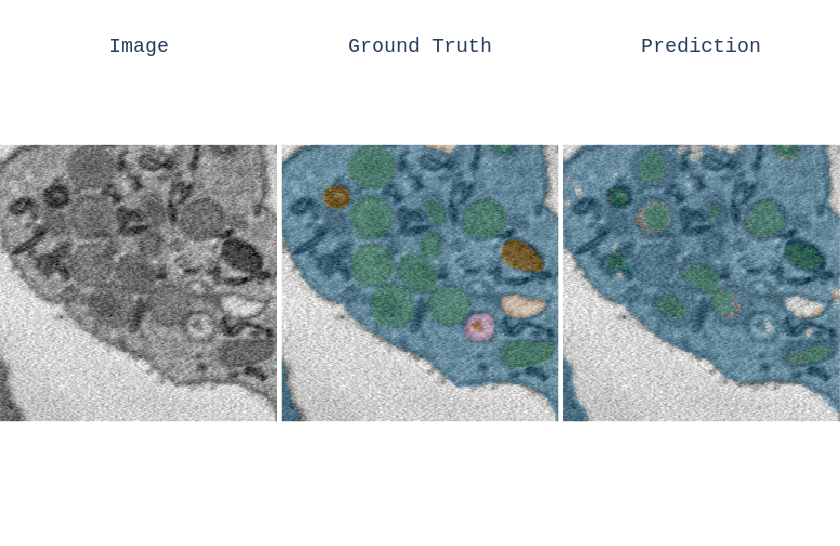

In [17]:
GridDisplay([ImageDisplay(image=image[:,:,0], title='Image'),
             ImageDisplay(image=image[:,:,0], masks=label[:,:,0], title='Ground Truth'),
             ImageDisplay(image=image[:,:,0], masks=pred_segment[:,:,0], title='Prediction')
            ]).show()

Visualization of multiple slices of the pipeline out which is generated offline.

<img src='https://github.com/fastestimator-util/fastestimator-misc/blob/master/resource/pictures/apphub/unet3d_3plus/sample_output.gif?raw=true' width="1000" height="500">

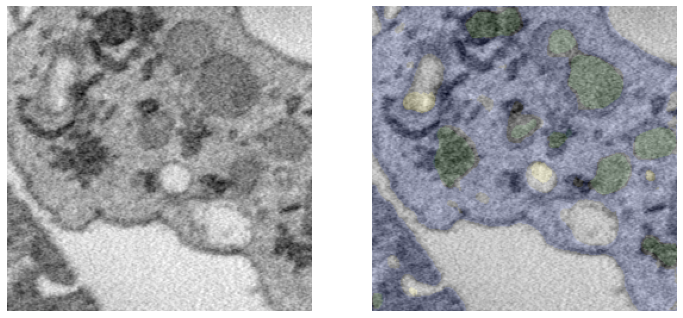

In [18]:
# adding ground truth layer
z = np.ones(pred_segment.shape[:-1] + (1,), dtype=pred_segment.dtype)
z[np.sum(pred_segment, axis=-1)==1] = 0
pred_segment_out = np.concatenate((z, pred_segment), axis=-1)

image = np.tile(np.expand_dims(image, -1), 3)

save_gif(image, pred_segment_out, color_mapping, 'prediction.gif')